# End2end ConvGRU

> Autoencoder + forecaster in the same training loop. Based on (https://github.com/tcapelle/moving_mnist/blob/master/01_train_example.ipynb) and (https://github.com/tcapelle/moving_mnist/blob/master/02_train_cross_entropy_loss-Copy1.ipynb)

In [1]:
import sys
sys.path.append('..')
from fastai.vision.all import *
from mocatml.utils import *
convert_uuids_to_indices()
from mocatml.data import *
from mocatml.models.conv_rnn import *
from mygrad import sliding_window_view
from tsai.imports import my_setup
from tsai.utils import yaml2dict, dict2attrdict
my_setup()
from fastai.callback.schedule import valley, steep
from fastai.callback.wandb import WandbCallback
import wandb

os              : Linux-6.2.0-36-generic-x86_64-with-glibc2.31
python          : 3.9.17
tsai            : 0.3.8
fastai          : 2.7.13
fastcore        : 1.5.29
torch           : 2.1.1+cu121
device          : cpu
cpu cores       : 4
threads per cpu : 2
RAM             : 15.3 GB
GPU memory      : N/A


In [89]:
config_base = yaml2dict('./config/base.yaml', attrdict=True)
config_base.convgru = yaml2dict('./config/convgru/convgru.yaml', attrdict=True)
#config = AttrDict({**config_base, **config_e2e})
config = AttrDict(config_base)
config

```json
{ 'bs': 64,
  'convgru': { 'attn': False,
               'blur': False,
               'coord_conv': False,
               'debug': False,
               'ks': 3,
               'n_in': 1,
               'n_out': 1,
               'norm': None,
               'rnn_ks': 5,
               'strategy': 'zero',
               'szs': [16, 64, 96]},
  'data': {'path': '~/data/mc_density_data/comb_am_rp.npy'},
  'device': 'cuda',
  'horizon': 4,
  'lookback': 4,
  'lr_max': 0.001,
  'mmap': 'True,',
  'n_epoch': 10,
  'normalize': True,
  'seed': 42,
  'sel_steps': 50,
  'stride': 5,
  'tmp_folder': 'tmp',
  'wandb': { 'enabled': False,
             'group': None,
             'log_learner': False,
             'mode': 'offline',
             'project': 'mocatml'}}
```

In [3]:
# Set device
default_device(0 if config.device == 'cpu' else config.device)

device(type='cpu')

In [4]:
run = wandb.init(project=config.wandb.project, 
                 config=config,
                 group=config.wandb.group,
                 mode=config.wandb.mode, 
                 anonymous='never') if config.wandb.enabled else None
config = dict2attrdict(run.config) if config.wandb.enabled else config
print(config)

{'bs': 64, 'data': {'path': '~/data/mc_density_data/comb_am_rp.npy'}, 'device': 'cuda', 'horizon': 4, 'lr_max': 0.001, 'lookback': 4, 'mmap': 'True,', 'n_epoch': 10, 'normalize': True, 'seed': 42, 'sel_steps': 50, 'stride': 5, 'tmp_folder': 'tmp', 'wandb': {'enabled': False, 'log_learner': False, 'mode': 'offline', 'group': None, 'project': 'mocatml'}, 'convgru': {'n_in': 1, 'n_out': 1, 'szs': [16, 64, 96], 'ks': 3, 'rnn_ks': 5, 'blur': False, 'attn': False, 'norm': None, 'strategy': 'zero', 'coord_conv': False, 'debug': False}}


In [5]:
data = np.load(Path(config.data.path).expanduser(), 
               mmap_mode='c' if config.mmap else None)
data = data[:, :config.sel_steps]
data.shape

(100, 50, 36, 99)

In [6]:
data_sw = sliding_window_view(data, (data.shape[0], config.lookback + config.horizon, 
                                 data.shape[-2], data.shape[-1]), 
                                 (data.shape[0], config.stride, 
                                  data.shape[-2], data.shape[-1]))
samples_per_simulation = data_sw.shape[1]
data_sw = data_sw.squeeze().transpose([1,0,2,3,4])
data_sw = data_sw.reshape(-1, *data_sw.shape[2:])
data_sw.shape

(900, 8, 36, 99)

Split and get Normalization statistics from training set (mean and standard deviation)

In [7]:
# Split by simulation
splits = RandomSplitter()(data)
splits

((#80) [34,70,71,21,55,81,90,26,46,10...],
 (#20) [77,57,54,62,44,8,50,52,40,12...])

In [8]:
ds = DensityData(data_sw, lbk=config.lookback, h=config.horizon)
train_idxs = calculate_sample_idxs(splits[0], samples_per_simulation)
valid_idxs = calculate_sample_idxs(splits[1], samples_per_simulation)
len(train_idxs), len(valid_idxs)

(720, 180)

In [9]:
mocat_stats = (np.mean(data[splits[0]]), np.std(data[splits[0]]))
mocat_stats

(63.88998028900112, 188.46569792224875)

(4, 4)

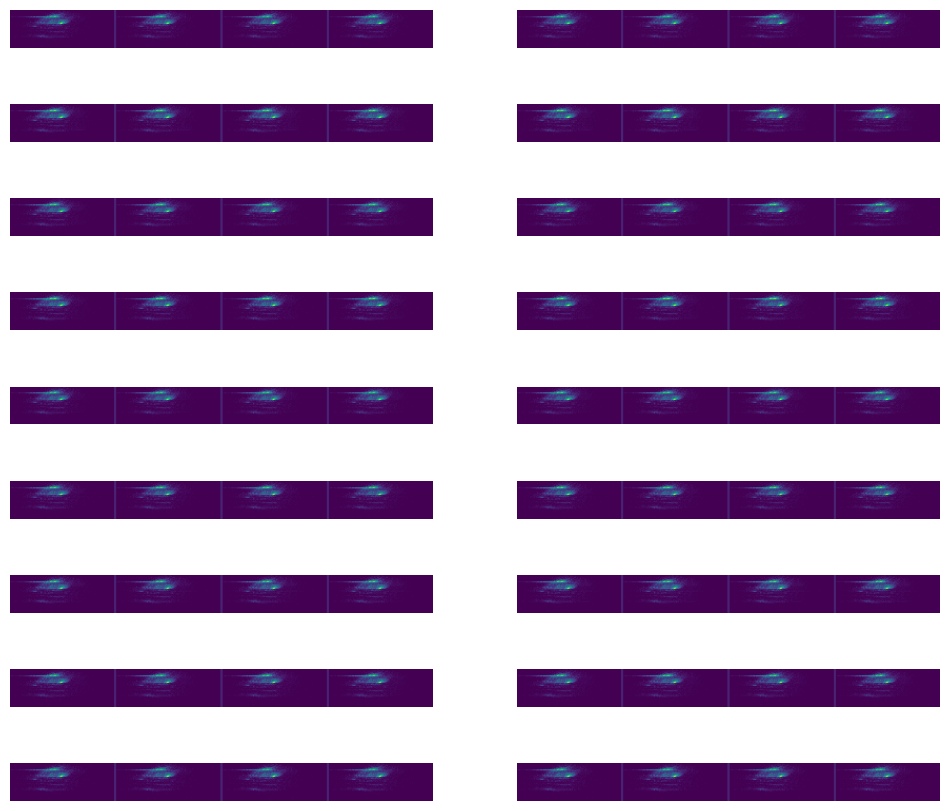

In [10]:
# Create dataloaders
train_tl = TfmdLists(train_idxs, DensityTupleTransform(ds))
valid_tl = TfmdLists(valid_idxs, DensityTupleTransform(ds))
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=config.bs, device=default_device(),
                            after_batch=[Normalize.from_stats(*mocat_stats)] if \
                             config.normalize else None)
dls.show_batch()
foo, bar = dls.one_batch()
len(foo), len(bar)

In [11]:
loss_func = StackLoss(MSELossFlat())

In [93]:
config.convgru.norm = NormType.Batch if config.convgru.norm == 'batch' else None
model = StackUnstack(SimpleModel(**config.convgru)).to(default_device())
wandbc = WandbCallback(log_preds=False, log_model=False) if config.wandb.enabled else None
cbs = L() + wandbc
learn = Learner(dls, model, loss_func=loss_func, cbs=cbs)
#lr_max = ifnone(config.lr_max, learn.lr_find())

In [94]:
learn.summary()

StackUnstack (Input shape: 64 x torch.Size([64, 1, 36, 99]) x torch.Size([64, 1, 36, 99]) x torch.Size([64, 1, 36, 99]))
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 1 x 36 x 9 
Lambda                                                         
____________________________________________________________________________
                     64 x 16 x 36 x 99   
Conv2d                                    160        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 18 x 50   
Conv2d                                    9280       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 96 x 9 x 25    
Conv2d                                    55392      True      
ReLU                            

In [105]:
learn.fit_one_cycle(config.n_epoch, lr_max=lr_max)

epoch,train_loss,valid_loss,time
0,207841.234375,117300.992188,02:08
1,5181.748047,3817.242432,02:09
2,2288.431396,1783.425903,02:08
3,1359.413452,1263.395142,02:08
4,1003.579346,1147.064087,02:09
5,729.376282,871.822144,02:10
6,601.165405,608.606934,02:09
7,484.418915,511.980621,02:09
8,447.173615,482.623291,02:09
9,436.162262,472.309662,02:09


In [106]:
p,t = learn.get_preds()
len(p), p[0].shape

(4, torch.Size([9720, 1, 36, 99]))

In [107]:
def show_res(t, idx, figsize=(8,4)):
    density_seq = DensitySeq.create([t[i][idx] for i in range(len(t))])
    density_seq.show(figsize=figsize);

6083


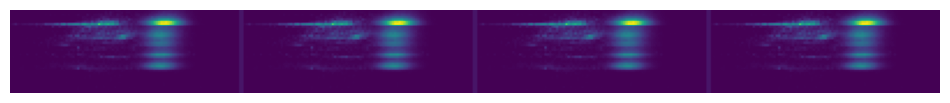

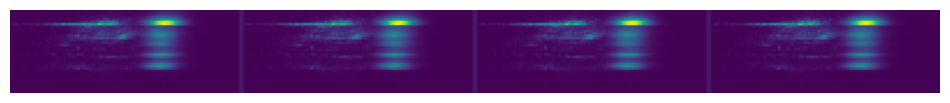

In [108]:
k = random.randint(0, dls.valid.n)
figsize=(12,8)
print(k)
show_res(t,k, figsize=figsize)
show_res(p,k, figsize=figsize)

In [109]:
# Print the validation loss and save it in case other notebooks (optuna) wants to
# use it for hyperparameter optimization
valid_loss = learn.validate()[0] 
print(valid_loss)
%store valid_loss

472.3096618652344
Stored 'valid_loss' (float)


In [122]:
# Remove the wandb callback to avoid errors when downloading the learner
if config.wandb.enabled:
    learn.remove_cb(wandb_callback)

# Save locally and in wandb if online and enabled
learn.model_dir = config.tmp_folder
learn.save('model', with_opt=True)
learn.export(f'{config.tmp_folder}/learner.pkl')
if run is not None and config.wandb.log_learner:
    # Save the learner (all tmp/dls, tmp/model.pth, and tmp/learner.pkl). 
    run.log_artifact(config.tmp_folder, type='learner', name=config.wandb.project)

OverflowError: serializing a string larger than 4 GiB requires pickle protocol 4 or higher

In [ ]:
if run is not None:
    run.finish()